In [1]:
from __future__ import print_function
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import poisson
from scipy.stats import expon

%matplotlib inline  

# Boils down to "If I pick hosts 2 * (rf - 1) * vnode times, how many
# distinct hosts will I have in expectation". Note that this is a slightly
# optimistic estimate because Cassandra won't place two replicas of the
# same token on the same machine or rack, but this is close enough for
# the model
# This is a variant of the Birthday Problem where we are interested
# in the number of distinct values produced
# http://www.randomservices.org/random/urn/Birthday.html
def num_neighbors(n, v, rf, strategy="rack"):
    k = 2 * v * (rf - 1)
    if strategy == "rack":
        # As cassandra is rack aware, we assume #racks == #replicas
        # This is maybe a bad assumption for some datacenter deployments
        n = n - (n // rf)
    else:
        # SimpleStrategy
        n = n - 1
    estimate = (n * (1.0 - (1.0 - 1.0/n) ** k))
    return max(rf - 1, min(estimate, n))

def p_outage_given_failure(recovery_seconds, num_neighbors, rate_in_seconds):
    x = math.exp(-1 * recovery_seconds * num_neighbors * rate_in_seconds)
    return 1 - x

def global_rate(node_rate, nodes, split_probability):
    return node_rate * nodes * split_probability

def recovery_seconds(size, bw_in, bw_out, neighbors, recovery='streaming'):
    if recovery == 'ebs':
        return 60 * 5
    return int(size / (min(bw_in, neighbors * bw_out)))
    

# Default model
nodes = 96
vnodes = 256
rf = 3
# 1000 gigabytes
node_dataset_mb = 300 * 1024
# MB/s
bw_in = 125
# MB/s, cassandra.yaml has 25MBPS as the default
# but most operators observe maybe half of that 
bw_out = 25 / 2
strategy = 'rack'

year_seconds = 60.0*60*24*365
century_seconds = 100 * year_seconds

# Model machines that fail on average 
# 25 times per century a.k.a 1 in 4 machines
# fails per year, or a machine fails every
# 4 years
arate = 25
arate_in_seconds = 25 / century_seconds


print("\nFailure Rate Variability")
print("Neighbors for {0} vnodes: {1:.3f}".format(1, num_neighbors(nodes, 1, rf)))
print("Neighbors for {0} vnodes: {1:.3f}".format(4, num_neighbors(nodes, 4, rf)))
print("Neighbors for {0} vnodes: {1:.3f}".format(16, num_neighbors(nodes, 16, rf)))

aneighbors = num_neighbors(nodes, vnodes, rf)
arecovery = recovery_seconds(node_dataset_mb, bw_in, bw_out, aneighbors)
print("Neighbors for {0} vnodes: {1:.3f}".format(vnodes, aneighbors))


def outage_stats(
        vnodes, failure_rate_per_century, num_nodes,
        rf, bw_in, bw_out,
        strategy='rack', recovery='streaming'):
    neighbors = num_neighbors(num_nodes, vnodes, rf, strategy)
    recovery_s = recovery_seconds(node_dataset_mb, bw_in, bw_out, neighbors, recovery)
    p_failure = p_outage_given_failure(
        recovery_s, neighbors, failure_rate_per_century / century_seconds)
    
    lmb = global_rate(failure_rate_per_century, num_nodes, p_failure)
    return (
        poisson.mean(lmb), poisson.interval(0.50, lmb), poisson.median(lmb),
        expon.mean(scale=1/lmb), expon.interval(0.50, scale=1/lmb)
    )

# Returns outages _per century_
def compute_outage(
        vnodes, failure_rate_per_century, num_nodes,
        rf, bw_in, bw_out,
        strategy='rack', recovery='streaming'):
    return outage_stats(
        vnodes, failure_rate_per_century, num_nodes, rf, bw_in, bw_out, strategy
    )[0]

print("{0:<6} {1:<8} {2:<8} {3:<8} -> {4:<6}".format(
    "rate", "rec_s", "p_fail", "g_lmb", "outages"
))
for rate in (12.5, 25, 50, 100, 200):
    recovery_s = recovery_seconds(node_dataset_mb, bw_in, bw_out, aneighbors)
    p_failure = p_outage_given_failure(
        recovery_s, aneighbors, rate / century_seconds)
    gl = global_rate(rate, nodes, p_failure)
    p = "{0:6.2f} {1:6.2f} {2:8.6f} {3:8.4f} -> {4:6.6f}".format(
        rate, recovery_s, p_failure, gl, poisson.mean(gl)
    )
    print(p)



Failure Rate Variability
Neighbors for 1 vnodes: 3.907
Neighbors for 4 vnodes: 14.255
Neighbors for 16 vnodes: 40.641
Neighbors for 256 vnodes: 64.000
rate   rec_s    p_fail   g_lmb    -> outages
 12.50 2457.00 0.000623   0.7477 -> 0.747712
 25.00 2457.00 0.001246   2.9899 -> 2.989917
 50.00 2457.00 0.002490  11.9522 -> 11.952217
100.00 2457.00 0.004974  47.7493 -> 47.749343
200.00 2457.00 0.009923 190.5224 -> 190.522373


[0.11687275130238817, 0.11685442306346161, 0.1287871379552552]
[0.4674682398095875, 0.4673949339935035, 0.5151209082762342]
[1.05175232074739, 1.051587398724152, 1.1589598500957976]
[1.8696908537753743, 1.8693976876205554, 2.06026250847966]


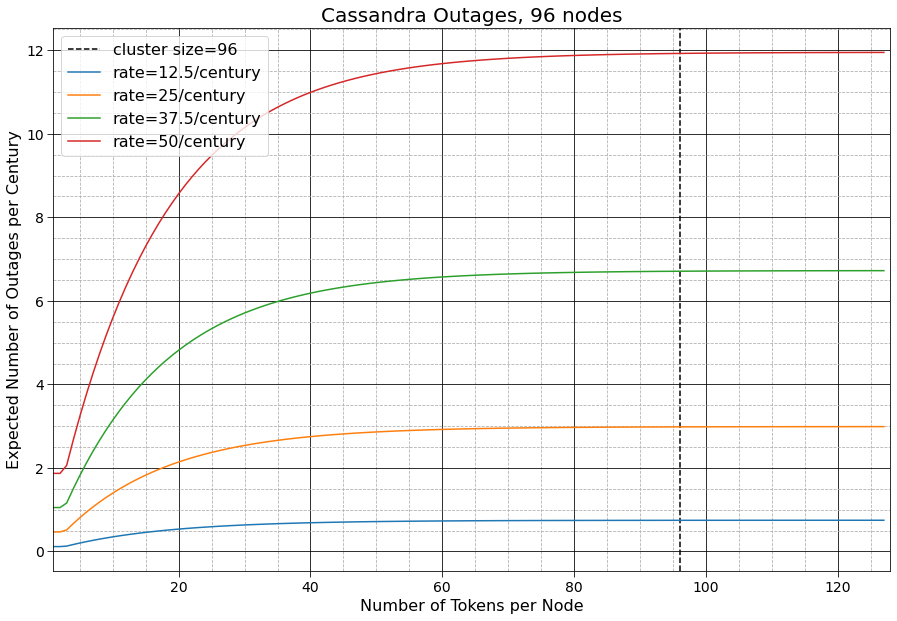

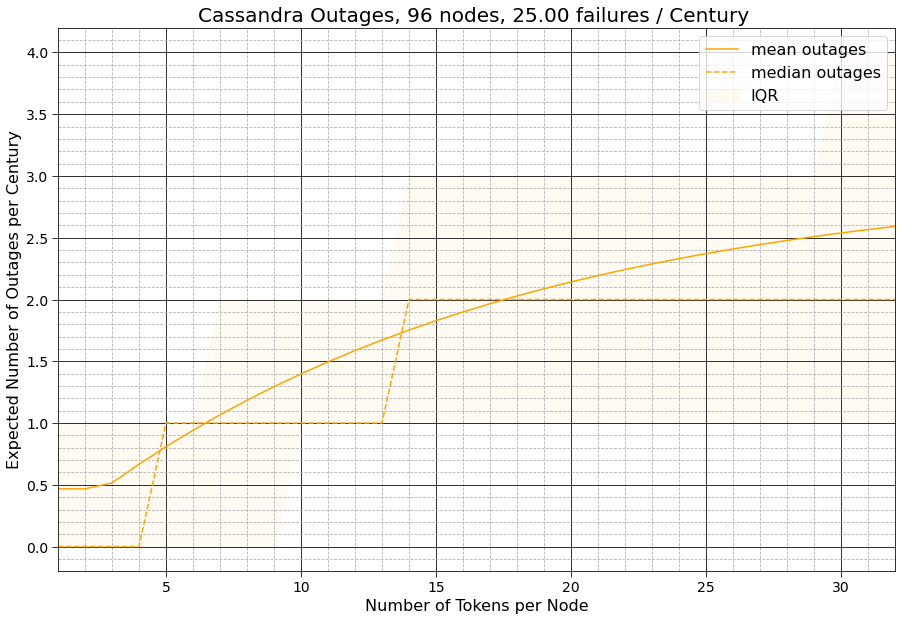

In [2]:
plt.figure(figsize=(15,10))
plt.title("Cassandra Outages, {0} nodes".format(nodes), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Tokens per Node", fontsize=16)
plt.xlim(1, 128)
plt.axvline(x=96, color='k', linestyle='--', label='cluster size={0}'.format(nodes))
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = range(1, 128)
rates = [12.5, 25, 37.5, 50]
for rate in rates:
    outages = []
    for vnode in num_vnodes:
        outages.append(compute_outage(vnode, rate, nodes, rf, bw_in, bw_out))
    print(outages[:3])
    plt.plot(num_vnodes, outages, label="rate={0}/century".format(rate))
plt.legend(fontsize=16)

outages = [outage_stats(v, arate, nodes, rf, bw_in, bw_out) for v in num_vnodes[:32]]
outage_mean = [o[0] for o in outages]
outage_lower = [o[1][0] for o in outages]
outage_upper = [o[1][1] for o in outages]
outage_median = [o[2] for o in outages]

plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Outages, {0} nodes, {1:.2f} failures / Century ".format(
        nodes, arate), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Tokens per Node", fontsize=16)
plt.xlim(1, 32)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)
plt.plot(num_vnodes[:32], outage_mean, color='orange', label='mean outages')
plt.plot(num_vnodes[:32], outage_median, color='orange', label='median outages', linestyle='--')
plt.fill_between(num_vnodes[:32], outage_lower, outage_upper, color='orange', alpha=0.05, label='IQR')
plt.legend(fontsize=16)


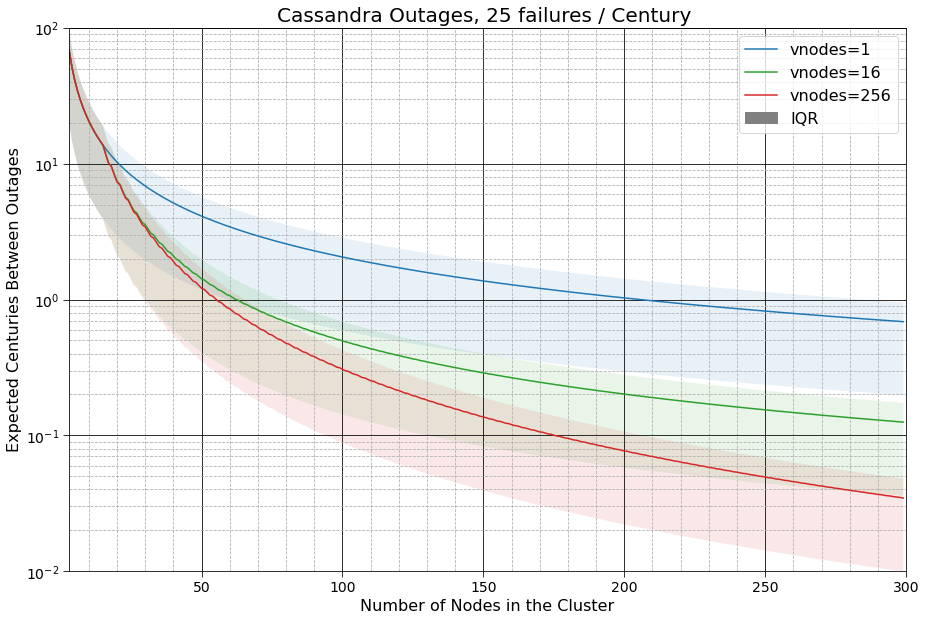

In [3]:
# Hold failures constant, vary size of cluster
# Look at MTBF
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Outages, {1} failures / Century ".format(
        vnodes, arate), fontsize=20)
plt.ylabel("Expected Centuries Between Outages", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gca().set_prop_cycle('color', colors[0:1] + colors[2:])

num_vnodes = (1, 16, 256)
num_nodes = range(3, 300)
lines = []

for v in num_vnodes:
    outages = [outage_stats(v, arate, n, rf, bw_in, bw_out) for n in num_nodes]
    outage_mean = [o[3] for o in outages]
    outage_lower = [o[4][0] for o in outages]
    outage_upper = [o[4][1] for o in outages]
    line, = plt.semilogy(num_nodes, outage_mean, label="vnodes={0}".format(v))
    lines.append(line)
    plt.fill_between(
        num_nodes, outage_lower, outage_upper, alpha=0.1,
        label='vnodes={0} IQR'.format(v)
    )

plt.xlim(3, 300)
plt.ylim(1/100.0, 100)

iqr_patch = mpatches.Patch(color='gray', label='IQR')
plt.legend(
    handles=lines + [iqr_patch], loc='upper right', fontsize=16
)

1 [0.014610448859836422, 0.01947965911340832, 0.02434859634069253]
4 [0.014610448859836422, 0.019479433162095106, 0.02434995460075251]
16 [0.014610448859836422, 0.019480598479670874, 0.024350747854035015]
256 [0.014610448859836422, 0.019480598479781897, 0.02435074809972737]


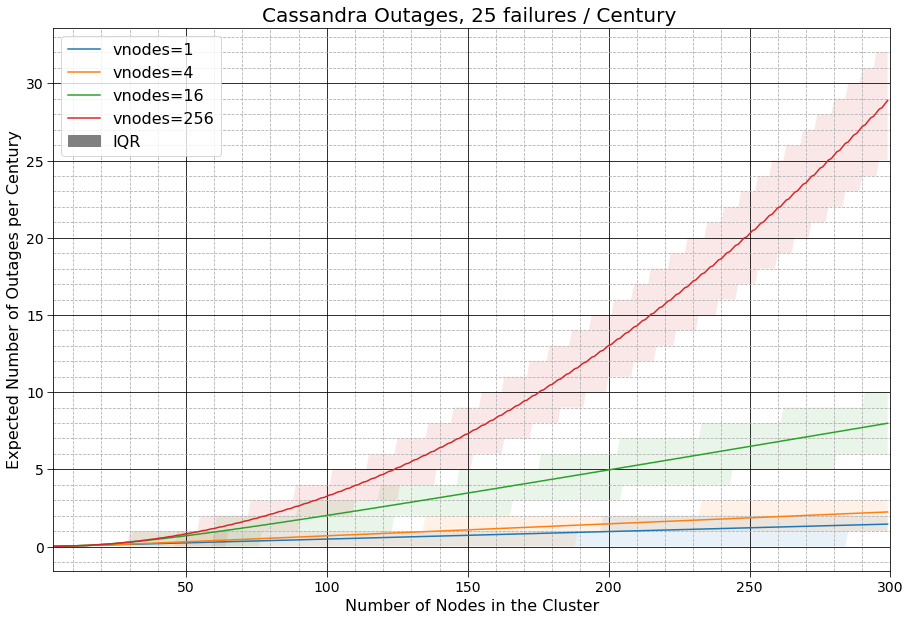

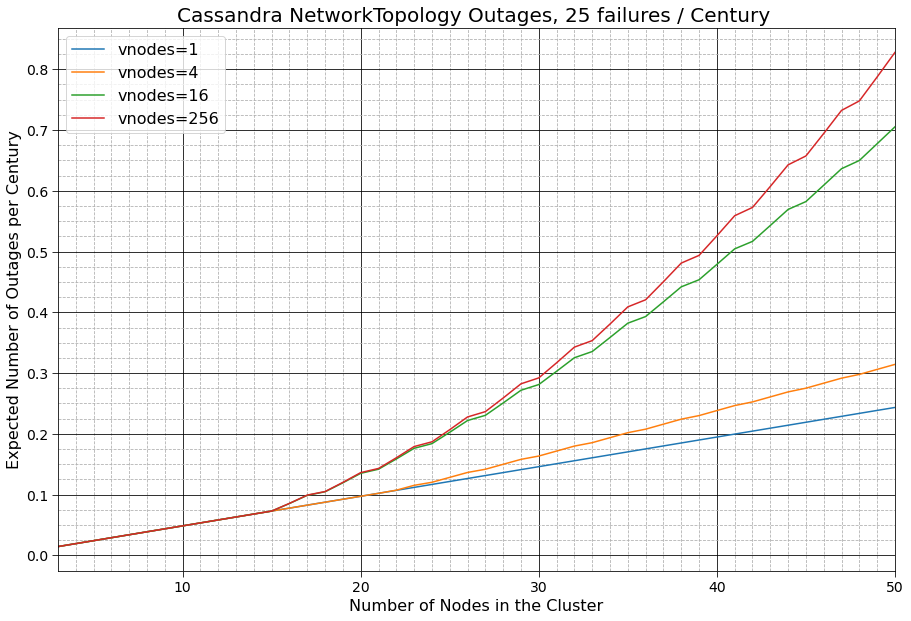

In [4]:

# Hold failures constant, vary size of cluster
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Outages, {1} failures / Century ".format(
        vnodes, arate), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = (1, 4, 16, 256)
num_nodes = range(3, 300)
lines = []
for v in num_vnodes:
    outages = [outage_stats(v, arate, n, rf, bw_in, bw_out) for n in num_nodes]
    outages = [outage_stats(v, arate, n, rf, bw_in, bw_out) for n in num_nodes]
    outage_mean = [o[0] for o in outages]
    outage_lower = [o[1][0] for o in outages]
    outage_upper = [o[1][1] for o in outages]
    line, = plt.plot(num_nodes, outage_mean, label="vnodes={0}".format(v))
    lines.append(line)
    plt.fill_between(
        num_nodes, outage_lower, outage_upper, alpha=0.1,
        label='vnodes={0} IQR'.format(v)
    )

plt.xlim(3, 300)
iqr_patch = mpatches.Patch(color='gray', label='IQR')
plt.legend(
    handles=lines + [iqr_patch], loc='upper left', fontsize=16
)


# Hold failures constant, vary size of cluster, NetworkTopologyStrategy
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra NetworkTopology Outages, {0} failures / Century ".format(
        arate), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(10))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = (1, 4, 16, 256)
num_nodes = range(3, 51)
for v in num_vnodes:
    outages = [compute_outage(v, arate, n, rf, bw_in, bw_out, 'rack') for n in num_nodes]
    print(v, outages[:3])
    plt.plot(num_nodes, outages, label="vnodes={0}".format(v))

plt.xlim(3, 50)
plt.legend(fontsize=16)

1 [0.014610448859836422, 0.01947965911340832, 0.02434859634069253]
4 [0.014610448859836422, 0.019479433162095106, 0.02434995460075251]
16 [0.014610448859836422, 0.019480598479670874, 0.024350747854035015]
256 [0.014610448859836422, 0.019480598479781897, 0.02435074809972737]


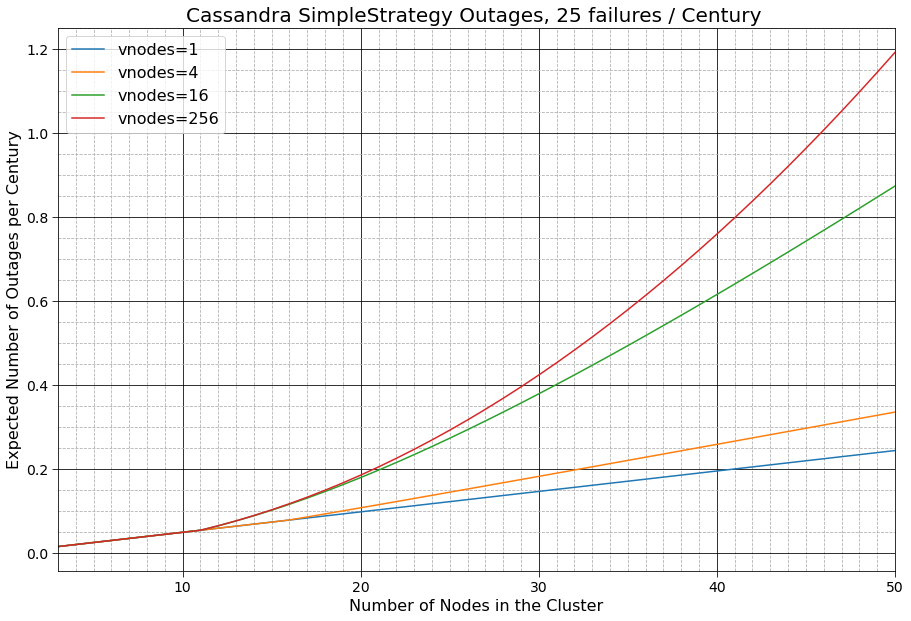

In [5]:
# Hold failures constant, vary size of cluster
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra SimpleStrategy Outages, {0} failures / Century ".format(
        arate), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(10))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = (1, 4, 16, 256)
num_nodes = range(3, 51)
for v in num_vnodes:
    outages = [compute_outage(v, arate, n, rf, bw_in, bw_out, 'simple') for n in num_nodes]
    print(v, outages[:3])
    plt.plot(num_nodes, outages, label="vnodes={0}".format(v))

plt.xlim(3, 50)
plt.legend(fontsize=16)

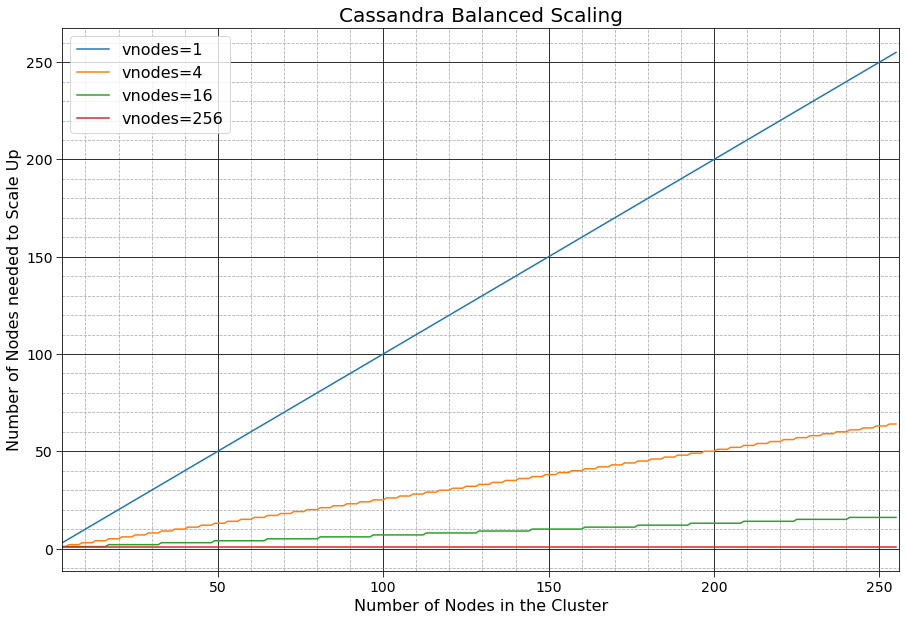

In [6]:
# Observe impact of vnodes on Scale Up Balancing 
plt.figure(figsize=(15,10))
plt.title("Cassandra Balanced Scaling",fontsize=20)
plt.ylabel("Number of Nodes needed to Scale Up", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = (1, 4, 16, 256)
num_nodes = range(3, 256)
for v in num_vnodes:
    scale_up = [math.ceil(float(n) / v) for n in num_nodes]
    plt.plot(num_nodes, scale_up, label="vnodes={0}".format(v))

plt.xlim(3, 256)

plt.legend(fontsize=16)

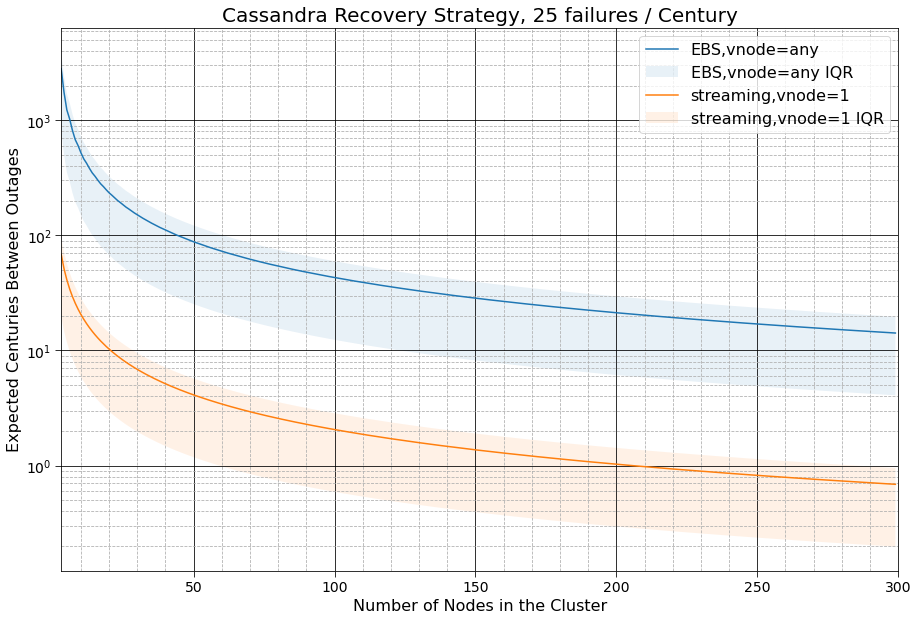

In [7]:
# Observe impact of EBS on availability
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Recovery Strategy, {0} failures / Century".format(arate), fontsize=20)
plt.ylabel("Expected Centuries Between Outages", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_nodes = range(3, 300)
lines = []

# Plot fixed recovery speed
outages = [outage_stats(1, arate, n, rf, bw_in, bw_out, recovery='ebs') for n in num_nodes]
outage_mean = [o[3] for o in outages]
outage_lower = [o[4][0] for o in outages]
outage_upper = [o[4][1] for o in outages]
line, = plt.semilogy(num_nodes, outage_mean, label="EBS,vnode=any")
lines.append(line)
plt.fill_between(
    num_nodes, outage_lower, outage_upper, alpha=0.1,
    label='EBS,vnode=any IQR'.format(v)
)

outages = [outage_stats(1, arate, n, rf, bw_in, bw_out, recovery='recovery') for n in num_nodes]
outage_mean = [o[3] for o in outages]
outage_lower = [o[4][0] for o in outages]
outage_upper = [o[4][1] for o in outages]
line, = plt.semilogy(num_nodes, outage_mean, label="streaming,vnode=1")
lines.append(line)
plt.fill_between(
    num_nodes, outage_lower, outage_upper, alpha=0.1,
    label='streaming,vnode=1 IQR'
)

plt.xlim(3, 300)

plt.legend(fontsize=16)

In [8]:
import itertools
import random
import sys

def simulate(l):
    return random.expovariate(l)

def offset(values, max_value=float("inf")):
    nvalues = values[:1] + [0] * (len(values) - 1)
    for i in range(1,len(values)):
        nvalues[i] = values[i] + nvalues[i-1]
    return [n for n in nvalues if n <= max_value]

def outage(o, f_i, t, neighbors):
    failures = 0
    neighbor_indices = range(0, len(o))
    neighbor_indices.remove(f_i)
    random.shuffle(neighbor_indices)
    for n in range(int(round(neighbors))):
        failures += near(o[neighbor_indices[n]], o[f_i], t)
    return failures

def near(a, b, t):
    failures = 0
    for i in a:
        for j in b:
            if j > i + t:
                break
            if j - i > 0 and j - i < t:
                failures += 1
    return failures

def run_simulate(l, neighbors, nodes):
    rs = []
    for r in range(5):
        o = [offset([simulate(l) for j in range(300)]) for i in range(nodes)]
        maxes = [x[-1] for x in o]
        m = max(maxes)
        outages_per_century = (
            sum([outage(o, i, arecovery / century_seconds, neighbors) for i in range(nodes)]) /
            m
        )
        print("Run {0} gave {1:.3f} outages/century".format(r, outages_per_century))
        rs.append(outages_per_century)
    print("Simulation outages/century: ", sum(rs) / len(rs))
    
def run_simulate_naive(l, neighbors, nodes):
    p_split = p_outage_given_failure(arecovery, aneighbors, l / century_seconds)
    l_split = l * p_split
    l_global = nodes * l_split
    print(p_split, l_global)
    rs = []
    for r in range(10):
        events = 1000
        o = offset([simulate(l_global) for j in range(events)])
        ##failure_years = [int(x/year) for x in o]
        num_centuries = max(o)
        rs.append(events / num_centuries)
    print("Simple simulation outages/century: ", sum(rs) / len(rs))    
    
    
print(p_outage_given_failure(arecovery, num_neighbors(nodes, vnodes, rf), arate))
print(vnodes, arate, nodes, rf, bw_in, bw_out, arecovery, num_neighbors(nodes, vnodes, rf))
print("Predicted outages/century:", compute_outage(vnodes, arate, nodes, rf, bw_in, bw_out))
#run_simulate(arate, num_neighbors(nodes, vnodes, rf), nodes)
run_simulate_naive(arate, num_neighbors(nodes, vnodes, rf), nodes)
#run_simulate(arate, num_neighbors(nodes, vnodes, rf), nodes)

1.0
256 25 96 3 125 12.5 2457 63.999993652404335
Predicted outages/century: 2.9899165600627775
0.001245798566692824 2.9899165600627775
Simple simulation outages/century:  2.9636210683662436


# Frequency of Maintenance on a Fleet

Every time we perform maintenance on Cassandra we are "taking a chance" that another node will fail and cause an outage. In the Netflix fleet we choose vnode=1 to minimize the liklihood of outage, but we do do maintenance frequently.


In [9]:
from typing import Tuple
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.optimize import OptimizeResult
from scipy.special import gammainc as gammaf
from scipy.stats import beta as beta_dist
from scipy.stats import rv_continuous

# Parameter estimation of various scipy distributions using
# See https://www.johndcook.com/quantiles_parameters.pdf for
# background

EPSILON = 0.001

def _beta_cost_fn_from_params(low, mid, high, confidence):
    assert low <= mid <= high < 1.0
    assert mid > 0

    # Assume symmetric percentiles were provided
    confidence = min(confidence, 0.99)
    confidence = max(confidence, 0.01)

    low_p = 0.0 + (1 - confidence) / 2.0
    high_p = 1.0 - (1 - confidence) / 2.0

    def cost(alpha):
        beta = alpha / mid - alpha
        if alpha == 0 or beta == 0:
            return float("inf")

        cost = (beta_dist.cdf(low, alpha, beta) - low_p) ** 2
        cost += (beta_dist.cdf(high, alpha, beta) - high_p) ** 2
        return cost

    return cost


def _beta_dist_from_interval(
    minimum, low, mid, high, maximum, confidence: float=0.9, seed: int = 0xCAFE
) -> Tuple[Tuple[float, float, OptimizeResult], rv_continuous]:
    # If we know cdf(high), cdf(low) and mean (mid) we can use an iterative
    # solver to find a possible beta fit
    if minimum == maximum:
        minimum = low - EPSILON
        maximum = high + EPSILON
        scale = maximum - minimum
    else:
        minimum = minimum
        maximum = maximum
        scale = maximum - minimum

    lower = (low - minimum) / scale
    mean = (mid - minimum) / scale
    upper = (high - minimum) / scale

    f = _beta_cost_fn_from_params(lower, mean, upper, confidence)
    result = minimize(f, x0=2, bounds=[(0.1, 40)])
    alpha = result.x[0]

    dist = beta_dist(alpha, alpha / mean - alpha, loc=minimum, scale=scale)
    dist.random_state = np.random.default_rng(seed=seed)
    return (alpha, alpha / mean - alpha, result), dist

def beta_for_interval(
    minimum, low, mid, high, maximum,
    confidence: float=0.9, seed: int = 0xCAFE
) -> rv_continuous:
    result = _beta_dist_from_interval(minimum, low, mid, high, maximum, confidence, seed)[1]
    # Use the new Generator API instead of RandomState for ~20% speedup
    result.random_state = np.random.default_rng(seed=seed)
    return result

# https://stackoverflow.com/questions/14267555/find-the-smallest-power-of-2-greater-than-or-equal-to-n-in-python
def next_power_of_2(y: float) -> int:
    x = int(y)
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

def next_n(x: float, n: float) -> int:
    return int(math.ceil(x / n)) * int(n)

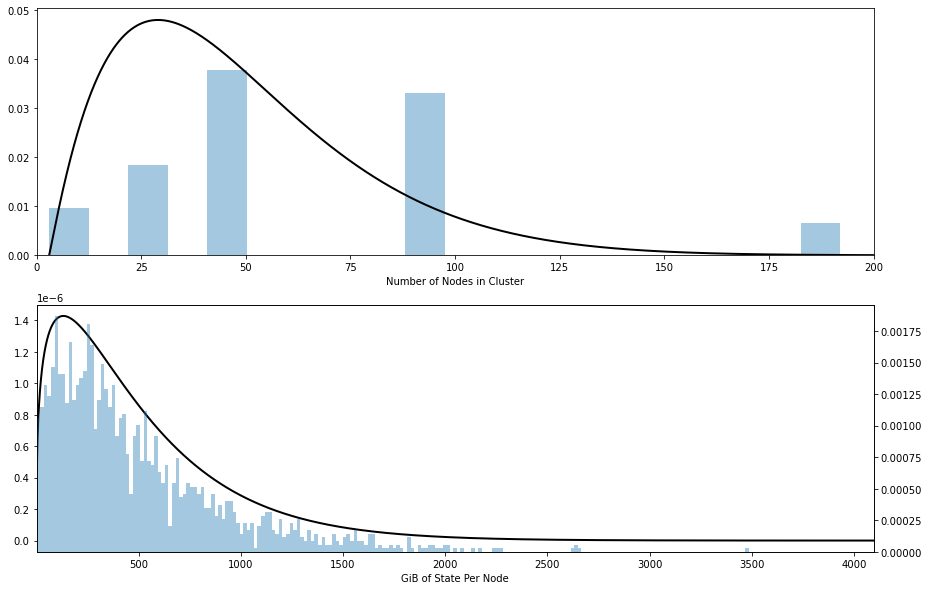

In [10]:
num_clusters = 2000
rf = 3

# 3 nodes min, 6 p05, 24 average, 200 p95, 
node_beta = beta_for_interval(
    minimum=1,
    low=4,
    mid=16,
    high=64,
    maximum=128
)

# 1GiB min, 50GiB p05, 500GiB average, 20TiB upper bound
node_dataset_beta = beta_for_interval(
    minimum=1024,
    low=1024 * 50,
    mid=1024 * 500,
    high=1024 * 1024 * 10,
    maximum=1024 * 1024 * 20
)

nodes = node_beta.rvs(num_clusters)
datasets = node_dataset_beta.rvs(num_clusters)

fleet = [
    (
        next_power_of_2(nodes[i]) * rf,
        next_n(datasets[i], 100)
    )
    for i in range(num_clusters)
]
fleet_df = pd.DataFrame(fleet, columns=['Nodes(#)', 'Storage(MiB)'])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
ax1.ticklabel_format(useOffset=False)

x = np.linspace(10, 40_000, 10000)

nodes_x = np.linspace(1, 200, 10000)
ax1.plot(nodes_x * rf, node_beta.pdf(nodes_x), 'k-', lw=2)
ax1.set_xlim(0, 200)
ax1.set_xlabel("Number of Nodes in Cluster")
ax1.hist([f[0] for f in fleet], density=True, histtype='stepfilled', alpha=0.4, bins=20)

space_in_gib = [int(f[1] / 1024) for f in fleet]
space_gib = np.linspace(1024, 1024 * 1024 * 4, 10000) / 1024
ax2.plot(space_gib, node_dataset_beta.pdf(space_gib * 1024), 'k-', lw=2, label='GiB / node')
ax2.set_xlim(1, 1024 * 4)
ax2.set_xlabel("GiB of State Per Node")

ax3 = ax2.twinx()
ax3.hist(space_in_gib, density=True, alpha=0.4, bins=200)
ax3.set_xlim(1, 1024 * 4)

plt.show()

In [11]:
reboot_time = 60 * 5

def p_outage_cluster(
    fail_per_year, num_nodes, dataset_mib, bw_in, bw_out,
    maint_strategy='in-place'
):
    neighbors = num_neighbors(num_nodes, 1, rf, strategy='rack')
    if maint_strategy == 'in-place':
        recovery_s = reboot_time
    elif maint_strategy == 'ebs':
        recovery_s = reboot_time + 60 * 5
    else:
        recovery_s = reboot_time + recovery_seconds(dataset_mib, bw_in, bw_out, neighbors, maint_strategy)
    p_failure = p_outage_given_failure(recovery_s, neighbors, fail_per_year / year_seconds)
    
    # Each zone has to do maintenance
    return p_failure * rf
    
    
def outages_per_year(maint_per_year, fail_per_year, fleet, strat='in-place'):
    p_cluster = []
    # 10Gbps vs 1 Gbps
    if strat == 'streaming-fast':
        bw_in = 125 * 10
        bw_out = 25 * 10
    else:
        bw_in = 125
        bw_out = 25
    for num_nodes, dataset_mib in fleet:
        p_fail = p_outage_cluster(fail_per_year, num_nodes, dataset_mib,
                                  bw_in=bw_in, bw_out=bw_out, maint_strategy=strat)
        p_cluster.append(1 - p_fail)
    p_any_fail = 1 - np.prod(p_cluster)
    return maint_per_year * p_any_fail  

In [12]:
rates = [1, 2, 4, 12, 24, 52, 365]
# hardware fails 1 in 4 years
failure_rate = 0.25 

def generate(rates, failure_rate):
    data = []
    for rate in rates:
        f_in_place = outages_per_year(rate, failure_rate, fleet, strat='in-place')
        f_ebs = outages_per_year(rate, failure_rate, fleet, strat='ebs')
        f_stream = outages_per_year(rate, failure_rate, fleet, strat='streaming')
        f_stream_fast = outages_per_year(rate, failure_rate, fleet, strat='streaming-fast')
        data.append((rate, f_in_place, f_ebs, f_stream, f_stream_fast))
    return pd.DataFrame(data, columns=['Rate', 'Imager', 'EBS', 'Streaming(1Gbps)', 'Streaming(10Gbps)'])
generate(rates, failure_rate=0.25)

,Rate,Imager,EBS,Streaming(1Gbps),Streaming(10Gbps)
0,1,0.052210,0.101695,0.638191,0.139137
1,2,0.104420,0.203390,1.276382,0.278273
2,4,0.208840,0.406780,2.552763,0.556547
3,12,0.626520,1.220339,7.658289,1.669640
4,24,1.253040,2.440679,15.316578,3.339281
5,52,2.714919,5.288137,33.185919,7.235108
6,365,19.056644,37.118657,232.939625,50.784895


In [13]:
df = generate(np.linspace(0.1, 365 * 25, 365), failure_rate=0.25)

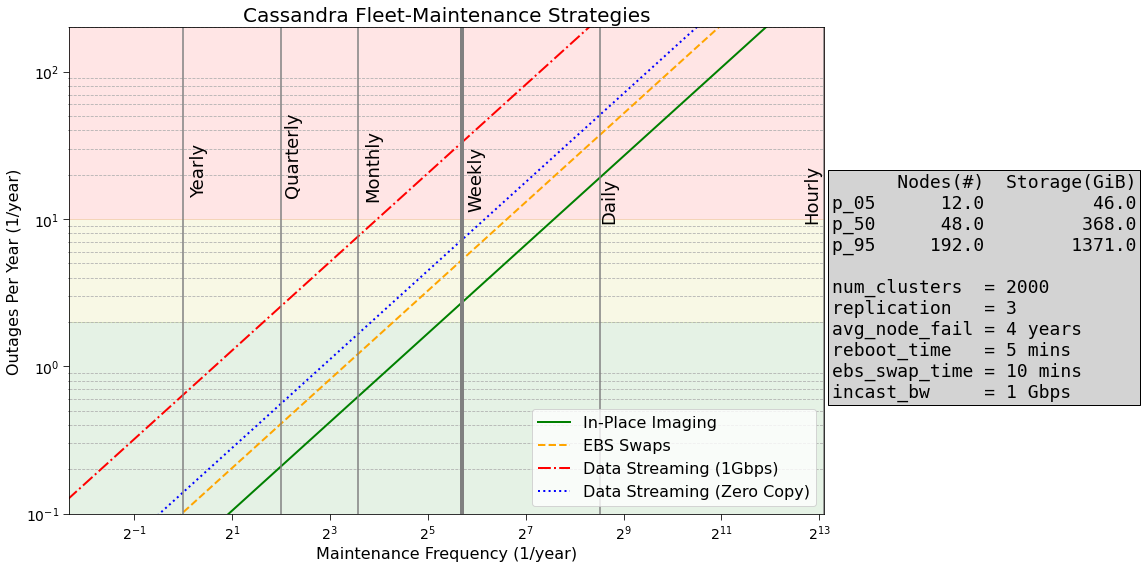

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))#, layout='constrained')

ax1.set_title("Cassandra Fleet-Maintenance Strategies",fontsize=20)
ax1.set_ylabel("Outages Per Year (1/year)", fontsize=16)
ax1.set_xlabel("Maintenance Frequency (1/year)", fontsize=16)
#ax1.grid(True, which='major', linestyle='-', color='k')
ax1.grid(True, which='minor', linestyle='--')
ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
ax1.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
ax1.tick_params(axis='both', which='major', labelsize=14, length=6)
ax1.tick_params(axis='both', which='minor', length=1)

x = df['Rate'].to_numpy()
ax1.plot(x, df['Imager'].to_numpy(), label="In-Place Imaging", linestyle='-', color='g', linewidth=2)
ax1.plot(x, df['EBS'].to_numpy(), label="EBS Swaps", linestyle='--', color='orange',  linewidth=2)
ax1.plot(x, df['Streaming(1Gbps)'].to_numpy(), label="Data Streaming (1Gbps)", linestyle='-.', color='r',  linewidth=2)
ax1.plot(x, df['Streaming(10Gbps)'].to_numpy(), label="Data Streaming (Zero Copy)", linestyle=':', color='blue',  linewidth=2)

ax1.axvline(x = 1, color = 'gray')
ax1.text(1.1, 15, 'Yearly',rotation=90, fontsize=18)

ax1.axvline(x = 4, color = 'gray')
ax1.text(4.2, 15, 'Quarterly',rotation=90, fontsize=18)

ax1.axvline(x = 12, color = 'gray')
ax1.text(13, 14, 'Monthly',rotation=90, fontsize=18)

ax1.axvline(x = 52, color = 'gray', linewidth=4)
ax1.text(56, 12, 'Weekly',rotation=90, fontsize=18)

ax1.axvline(x = 365, color = 'gray')
ax1.text(366.0, 10, 'Daily',rotation=90, fontsize=18)

ax1.axvline(x = (365 * 24), color = 'gray')
ax1.text(270 * 24, 10, 'Hourly',rotation=90, fontsize=18)

ax1.fill_between((.2, 8760), 10, 200, color = 'r', alpha=0.1)
ax1.fill_between((.2, 8760), 0, 2, color = 'g', alpha=0.1)
ax1.fill_between((.2, 8760), 2, 10, color = 'y', alpha=0.1)


ax1.set_xscale('log', base=2)
ax1.set_yscale('log', base=10)
ax1.set_xlim(.2, 365 * 24)
ax1.set_ylim(.1, 200)
ax1.legend(fontsize=16)

# fig.subplots_adjust(right=0.95)

box_style = {
    'facecolor':'lightgrey',
    'alpha': 1.0,
}
font_style = {
    'family': 'monospace',
    'color':  'black',
    'weight': 'normal',
    'size': 18,
}

fleet_df['Storage(GiB)'] = fleet_df['Storage(MiB)'].apply(lambda x: x // 1024)
def perc(n):
    def f_perc(x):
        return x.quantile(n)
    f_perc.__name__ = 'p_{:02.0f}'.format(n*100)
    return f_perc


summary = [perc(0.05), perc(0.50), perc(0.95)]
l = fleet_df.agg(
    {
        "Nodes(#)": summary,
        "Storage(GiB)": summary,
    }
).round()

text_box = f"""{l}

num_clusters  = {num_clusters}
replication   = {rf}
avg_node_fail = 4 years
reboot_time   = 5 mins
ebs_swap_time = 10 mins
incast_bw     = 1 Gbps"""
ax1.text(1.01, 0.70, text_box, transform=ax1.transAxes, fontdict=font_style,
        verticalalignment='top', bbox=box_style)
plt.tight_layout()
plt.savefig('maint.png', transparent=True)